# Pitch & Roll sequence prediction

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import json
import pickle
import multiprocessing
import platform
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [2]:
print(torch.__version__)
print(pl.__version__)

1.9.1
1.6.0


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 8
Platform: windows
number of workers: 0


# Constants

In [4]:
FRAMES_IN = 30
FRAMES_OUT = 10

N_EPISODES = 540
FRAMES_PER_EPISODE = 400
TRAIN_FOLDER = "../3dmodel/test_4_episode_"
SEQUENCE_LENGTH = 50

TRAIN_SIZE = 0.8
NUM_EPOCHS = 8
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

CUDA = device.type == 'cuda'
DEVICE = device

# Load data from episodes

In [5]:
# view first episode 
filename = TRAIN_FOLDER + "1/labels_0.json"
data = []
labels = json.load(open(filename))
ep1 = pd.DataFrame(labels)
ep1 = ep1.transpose()
ep1.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
ep1.head()

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [6]:
# load all data
episodes = [] # holds pitch, roll, episode number and position within episode number
pr_per_episode = [] # holds all pitch and roll tuples per episode
for ep in range(1, N_EPISODES+1):
    filename = "../3dmodel/test_4_episode_"+ str(ep) +"/labels_0.json"
    labels = json.load(open(filename))
    pr_in_current_episode = []
    for i in labels:
        pr_in_current_episode.append(labels[i])
        episodes.append(labels[i]+[ep, i])
    pr_per_episode.append(pr_in_current_episode)

In [7]:
p_r_df = pd.DataFrame(episodes)
# p_r_df.rename(columns = {0:'pitch', 1:'roll', 2:'episode', 3:'position_within_episode'}, inplace=True)
p_r_df.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df = p_r_df.drop([2,3], axis=1)     # drop episode and position_within_episode
p_r_df.head()

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [8]:
pr_per_episode_df = pd.DataFrame(pr_per_episode)
pr_per_episode_df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,"[15.9158690209565, 2.3584162956378014]","[14.29592488097425, 1.7003911752437184]","[6.2135895738216185, 1.6113252950233405]","[1.235337361757596, 6.175460896553669]","[1.341678284492817, 3.695467874019875]","[-0.0651516203579112, 3.0756651325514186]","[-4.392773839217525, 0.8726621608752939]","[-4.184235784139164, 0.35570707390756684]","[-3.3195511241318867, 6.666652243167843]","[5.894038319728926, -0.13849362470644613]",...,"[10.389031062517569, 1.5248242575580084]","[-1.2002740520448067, 0.5092731518638726]","[-10.535511299457662, -4.131095631735996]","[-18.896939235154417, -4.945806145463817]","[-22.184256348715486, -1.9589200251876364]","[-0.2044812962373426, 1.503336589150854]","[1.0747428590627885, 10.724272114907427]","[13.3735940647023, 1.5429493384594009]","[11.19363673825518, -0.8486316877453378]","[5.131548017300437, 0.9777773314587621]"
1,"[15.97866748773289, 2.268047343389832]","[9.855846859112509, 1.360887657924949]","[6.105283691039549, 1.5623034265245723]","[1.3507750292502163, 4.69679068181667]","[1.724415511875592, 4.076017413155836]","[0.03351754252109094, 3.1310278711991915]","[-7.604052164296134, 1.8397739918625224]","[-2.5471177738191515, 2.5391520656996245]","[-2.625542432756061, 7.979014181804202]","[6.084213411223707, 0.050736486104279443]",...,"[9.820045568804241, 1.8697905388306129]","[1.4623980360913844, 0.5153293418627053]","[-10.619933291372666, -3.1525508644909594]","[-15.18629041193054, -5.8295536500011895]","[-21.331025702502906, -4.46392562734884]","[-0.980658924236567, 0.000323666141662183]","[1.1033292284517018, 11.141469460921915]","[14.080388870204388, 0.990625450896085]","[11.345563197284712, -0.7964093420118897]","[4.760598735929752, 1.6810054975536355]"
2,"[15.961578354429518, 2.074803789410423]","[6.179635849683839, 0.12110205542910284]","[6.079602606647125, 1.6753055979695541]","[1.3610495547526196, 8.341244726699365]","[0.2675885889498374, 4.800268474629186]","[0.06658679384694029, 3.1533924718627517]","[-5.6663031642145985, 1.2498673085563288]","[-6.884764942802091, 0.6056172923359865]","[-2.0016676178818074, 6.428251747264541]","[6.3722296819184505, 0.18303076698380022]",...,"[9.64882211782213, 1.973062358750971]","[2.395990446922511, 0.4464584900686305]","[-10.690737593629956, -2.750964556154771]","[-14.010888280304924, -6.054184484537745]","[-21.49614211059338, -4.60819715186608]","[-4.0433481914688425, 1.2884030224101293]","[1.1818524982447534, 11.202268389818784]","[14.342162700334297, 0.7591126138013591]","[8.761085355922647, -0.30987522391631195]","[4.628031167442151, 1.9668671637303579]"
3,"[7.69906521829289, 1.5796155014713218]","[8.481780991514256, 0.05603940762328032]","[3.159275826059072, 0.8631695853111513]","[1.049441063612711, 2.2469629763088257]","[0.3593771266476851, 1.8488201505313813]","[-0.07217797069325685, 1.49066178576372]","[-2.60443416001296, 0.27787303957087833]","[-5.056486372756112, 0.3636566403690948]","[-1.834612289840697, 3.3018218740372376]","[2.911777518181313, -0.18950627990486155]",...,"[5.454093028683711, 0.6530340130189489]","[-1.6791362668768735, 0.18489125982090143]","[-5.466481284290821, -2.2171972253493215]","[-11.403407215591903, -1.6377460675585367]","[-9.300110224841715, 0.5591612804484688]","[-0.9304575674455022, 1.7758436346746147]","[0.5600581696638561, 4.948483152731639]","[6.361704787294284, 1.072871920838734]","[6.398844794679874, -0.44728280852408636]","[2.689249101248651, 0.22945817745416852]"
4,"[7.810402424405974, 1.4887826299683204]","[7.868472692729423, 0.18104613012244872]","[3.1332145989506532, 0.9057401800562839]","[0.9454851575582939, 2.1807891154219803]","[0.49654637500602317, 1.7821752200352163]","[-0.04738833270922448, 1.498974979757272]","[-2.617495189253317, 0.3204662326372101]","[-4.8539576034868945, 0.6764536111050119]","[-1.7194979891165945, 3.217247483526378]","[2.9227715614240943, -0.18400777751980293]",...,"[5.2915481868157475, 0.7305929454785594

In [84]:
# # converts p_r_df: rows now contain tuples of pr values, one row = all pr values for this episode
# df2 = p_r_df.copy()
# df2["pr"] = list(zip(p_r_df["pitch"].round(2), p_r_df["roll"].round(2)))
# df2.drop(columns=["pitch","roll"], axis=0, inplace=True)
# df2 = df2[["pr","episode","position_within_episode"]]
# rows = df2.groupby('episode')['pr'].apply(list)
# df_stack = pd.DataFrame(rows)
# df_stack = df_stack.reset_index()
# df_stack.head()

In [9]:
# Function to normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

# Function to normalize pitch and roll angles
def denorm_pr(x, min = -90.0, max = 90.0):
    return ((x + 1) * (max - min))/2 + min

In [10]:
# normalize PR-values
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
p_r_df.head()

,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
2,0.069040,0.017904
3,0.013726,0.068616
4,0.014908,0.041061


# Create sequences with target sequence

In [12]:
# function to create sequences with one target column
def create_sequences(input_data: pd.DataFrame, 
        output_feature_columns = ["pitch", "roll"],
        input_feature_columns = ["pitch", "roll"], 
        input_sequence_length=FRAMES_IN, 
        output_sequence_length=FRAMES_OUT, 
        episode_length = FRAMES_PER_EPISODE, 
        n_episodes = N_EPISODES
    ):
    sequences= []

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):
        for l in range(episode_length-output_sequence_length-input_sequence_length+1):

            i = l+(n*episode_length)

            # sequence = input_data.iloc[i:i+input_sequence_length][input_feature_columns]
            sequence = input_data.iloc[i:i+input_sequence_length].transpose()

            target_position = i + input_sequence_length
            # target = input_data.iloc[target_position:target_position+output_sequence_length][output_feature_columns]
            target = input_data.iloc[target_position:target_position+output_sequence_length].transpose()

            sequences.append((sequence, target))

    return sequences

In [13]:
input_features = ["pitch", "roll"]
target_features = ["pitch", "roll"]
all_sequences = create_sequences(p_r_df, target_features, input_features)

  0%|          | 0/540 [00:00<?, ?it/s]

In [14]:
len(all_sequences), all_sequences[0][0].shape, all_sequences[0][1].shape 

(194940, (2, 30), (2, 10))

In [15]:
all_sequences[0][0]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
pitch,0.176843,0.158844,0.069040,0.013726,0.014908,-0.000724,-0.048809,-0.046492,-0.036884,0.065489,...,0.095521,0.061482,0.116635,-0.102917,-0.038967,-0.096527,0.114990,0.067208,0.189211,0.141314
roll,0.026205,0.018893,0.017904,0.068616,0.041061,0.034174,0.009696,0.003952,0.074074,-0.001539,...,0.032069,0.029224,0.011919,0.005872,-0.054846,-0.037258,0.090525,0.103966,0.058648,0.100553


In [16]:
# loop for testing sequence integrity
"""
i = 0
for data in tqdm(all_sequences):
    input = data[0]
    output = data[1]

    episode = input.iloc[0]["episode"]
    episode1 = output.iloc[0]["episode"]
    
    if(episode1 != episode):
        print("Input and output from different episodes")
        break

    if (len(input['episode'].unique()) != 1):
        print("input seq: "+i+" contains data from different episodes")
        break
    
    if (len(output['episode'].unique()) != 1):
        print("output seq: "+i+" contains data from different episodes")
        break
    
    i += 1
"""

'\ni = 0\nfor data in tqdm(all_sequences):\n    input = data[0]\n    output = data[1]\n\n    episode = input.iloc[0]["episode"]\n    episode1 = output.iloc[0]["episode"]\n    \n    if(episode1 != episode):\n        print("Input and output from different episodes")\n        break\n\n    if (len(input[\'episode\'].unique()) != 1):\n        print("input seq: "+i+" contains data from different episodes")\n        break\n    \n    if (len(output[\'episode\'].unique()) != 1):\n        print("output seq: "+i+" contains data from different episodes")\n        break\n    \n    i += 1\n'

In [17]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print("Training size:", len(train_indices),"| Test size:", len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
Training size: 155952 | Test size: 38988
[167621, 29184, 6556, 194393, 72097, 64196, 58513, 36579, 193061, 26868]
[1, 131073, 4, 6, 131080, 11, 17, 131089, 21, 23]


In [18]:
# drop temporary episode and position_within_episode columns in all sequences
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
print(len(train_sequences), train_sequences[0][0].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0].shape, test_sequences[0][1].shape)

  0%|          | 0/155952 [00:00<?, ?it/s]

  0%|          | 0/38988 [00:00<?, ?it/s]

True
155952 (2, 30) (2, 10)
38988 (2, 30) (2, 10)


## Pytorch Dataset

In [19]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, labels = self.sequences[index]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            labels = torch.Tensor(labels.to_numpy())
        )

In [20]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = BATCH_SIZE):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [21]:
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [22]:
data_module_train_dataloader = data_module.train_dataloader()
data_module_train_dataloader.dataset.__getitem__(0)["sequence"].shape, data_module_train_dataloader.dataset.__getitem__(0)["labels"].shape

(torch.Size([2, 30]), torch.Size([2, 10]))

In [23]:
x_train = 0
y_train = 0

for batch in data_module_train_dataloader:
    x_train = batch["sequence"]
    y_train = batch["labels"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 2, 30]) torch.Size([64, 2, 10])


## LSTM Model

In [24]:
# ENCODER
class Encoder(nn.Module):

    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size=300, num_layers=1):
         
        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state 
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''

        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size

        self.encoder_lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,
        )

    def forward(self, input_seq):
        
        '''
        : param x_input:               input of shape (# in batch, seq_len, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence 
        '''

        ouputs, hidden = self.encoder_lstm(input_seq)
        
        return ouputs, hidden

In [25]:
# DECODER
class Decoder(nn.Module):

    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, output_size, hidden_size=300, num_layers = 1):

        '''
        : param output_size:    the number of features in the predicted output
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.decoder_lstm = nn.LSTM(
            input_size = hidden_size, 
            hidden_size = hidden_size,
            num_layers = num_layers, 
            batch_first = True
        )

        self.decoder_fc_1 = nn.Linear(hidden_size, int(hidden_size/2))
        self.decoder_fc_2 = nn.Linear(int(hidden_size/2), output_size)

        #self.linear = nn.Linear(hidden_size, output_size)           

    def forward(self, x_input, hidden):
        
        '''        
        : param x_input:                    should be 2D (batch_size, output_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        outputs = F.relu(x_input)

        outputs, hidden = self.decoder_lstm(outputs, hidden)

        outputs = F.relu(self.decoder_fc_1(outputs))
        outputs = torch.tanh(self.decoder_fc_2(outputs))

        return outputs, hidden

        #lstm_out, (hidden, _) = self.decoder_lstm(x_input)
        #output = self.linear(lstm_out.squeeze(1))     
        
        #return output, hidden

In [26]:
encoder = Encoder(input_size=FRAMES_IN)
decoder = Decoder(output_size=FRAMES_OUT)

encoder_outputs, encoder_hidden  = encoder.forward(x_train)

In [27]:
outputs, hidden = decoder.forward(encoder_outputs, encoder_hidden)
outputs.shape

torch.Size([64, 2, 10])

In [28]:
outputs[0][0:5]

tensor([[-0.0150,  0.0122, -0.0488, -0.0876,  0.0569, -0.0821,  0.0048, -0.0774,
         -0.0201,  0.0259],
        [-0.0175,  0.0125, -0.0536, -0.0883,  0.0568, -0.0808,  0.0013, -0.0767,
         -0.0195,  0.0256]], grad_fn=<SliceBackward>)

In [29]:
class LSTM_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size, output_size, hidden_size = 300):

        '''
        : param input_size:     the number of expected features in the input X
        : param output_size:    the number of features in the predicted output
        : param hidden_size:    the number of features in the hidden state h
        '''

        super(LSTM_seq2seq, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = Decoder(output_size = output_size, hidden_size = hidden_size)

    def forward(self, input_tensor):
        
        '''
        forward pass on lstm encoder-decoder
        
        : param input_tensor:              input data with shape (batch size, seq_len, number features); PyTorch tensor    
        '''

        encoder_outputs, encoder_hidden  = self.encoder.forward(input_tensor)

        decoder_outputs, decoder_hidden = self.decoder.forward(encoder_outputs, encoder_hidden)

        return decoder_outputs
                

In [30]:
lstm_seq2seq = LSTM_seq2seq(input_size=FRAMES_IN, output_size=FRAMES_OUT)

outputs = lstm_seq2seq.forward(x_train)

outputs.shape

torch.Size([64, 2, 10])

### Nazar's model

In [31]:
class LSTM_encoder_decoder_PR(nn.Module):
    def __init__(self, encoder_input_size = 10, encoder_hidden_size = 300, decoder_hidden_size = 300,  output_size = 20):
        super(LSTM_encoder_decoder_PR, self).__init__()

        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size

        self.encoder_lstm = nn.LSTM(encoder_input_size, encoder_hidden_size, batch_first=True)
        self.decoder_lstm = nn.LSTM(decoder_hidden_size, decoder_hidden_size, batch_first=True)

        self.decoder_fc_1 = nn.Linear(decoder_hidden_size, int(decoder_hidden_size/2))
        self.decoder_fc_2 = nn.Linear(int(decoder_hidden_size/2), output_size)


    def LSTM_encoder(self, inputs, hiddens):
        outputs, hiddens = self.encoder_lstm(inputs, hiddens)
        return outputs, hiddens


    def LSTM_decoder(self, inputs, hiddens):
        outputs = F.relu(inputs)
        outputs, hiddens = self.decoder_lstm(outputs, hiddens)
        outputs = F.relu(self.decoder_fc_1(outputs))
        outputs = torch.tanh(self.decoder_fc_2(outputs))
        return outputs, hiddens


    def initHiddenEncoder(self, n_batch):
        return  torch.zeros(1, n_batch, self.encoder_hidden_size)


    def initHiddenDecoder(self, n_batch):
        return  torch.zeros(1, n_batch, self.decoder_hidden_size)


    def forward(self, image_s, pr_s, use_n_im, predict_n_pr, encoder_hidden, decoder_hidden):

        PR  = [pr_s[i] for i in range(use_n_im)]
        lstm_input_features = torch.cat(PR, 1).view(pr_s[0].size(0), 1, -1)

        encoder_output, encoder_hidden = self.LSTM_encoder(lstm_input_features,  encoder_hidden)
        decoder_output, decoder_hidden = self.LSTM_decoder(encoder_output, decoder_hidden)

        decoder_output = decoder_output.view(pr_s[0].size(0), predict_n_pr, -1)

        return decoder_output, encoder_hidden, decoder_hidden

# Training

In [32]:
x_train = 0
y_train = 0

for batch in data_module_train_dataloader:
    x_train = batch["sequence"]
    y_train = batch["labels"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 2, 30]) torch.Size([64, 2, 10])


In [111]:
lstm_seq2seq = LSTM_seq2seq(input_size=FRAMES_IN, output_size=FRAMES_OUT)

outputs = lstm_seq2seq.forward(x_train)

outputs.shape

torch.Size([64, 2, 10])

In [113]:
outputs = lstm_seq2seq.forward(x_train)

In [114]:
model = LSTM_seq2seq(input_size=FRAMES_IN, output_size=FRAMES_OUT)

if CUDA:
    model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses_epoch = []
losses_all_batches = []

n_epochs = NUM_EPOCHS

for epoch in tqdm(range(n_epochs)):

    i = 0
    losses_batch = []

    for batch in data_module_train_dataloader:
        x_train = batch["sequence"]
        y_train = batch["labels"]

        if CUDA: 
            x_train = batch["sequence"].cuda()
            y_train = batch["labels"].cuda()
        
        # Predict on forward pass 
        y_pred = model.forward(x_train)
        if CUDA: 
            y_pred = y_pred.cuda()
        # Calculate loss/error
        loss = criterion(y_pred, y_train)
        losses_batch.append(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    losses_all_batches.append((epoch,losses_batch))

    # loss per epoch is average over all its batches
    sum = 0
    for l in losses_batch:
        sum += l
    
    mean = sum/len(losses_batch)
    losses_epoch.append(mean)
    if(epoch%1 == 0):
        print(f"EPOCH {epoch} training loss: {mean}")

  0%|          | 0/8 [00:00<?, ?it/s]

EPOCH 0 training loss: 0.004969937726855278
EPOCH 1 training loss: 0.0044121528044342995
EPOCH 2 training loss: 0.0036020083352923393
EPOCH 3 training loss: 0.002681469079107046
EPOCH 4 training loss: 0.0019868765957653522
EPOCH 5 training loss: 0.0015704097459092736
EPOCH 6 training loss: 0.0013172489125281572
EPOCH 7 training loss: 0.001149600138887763


## Training results

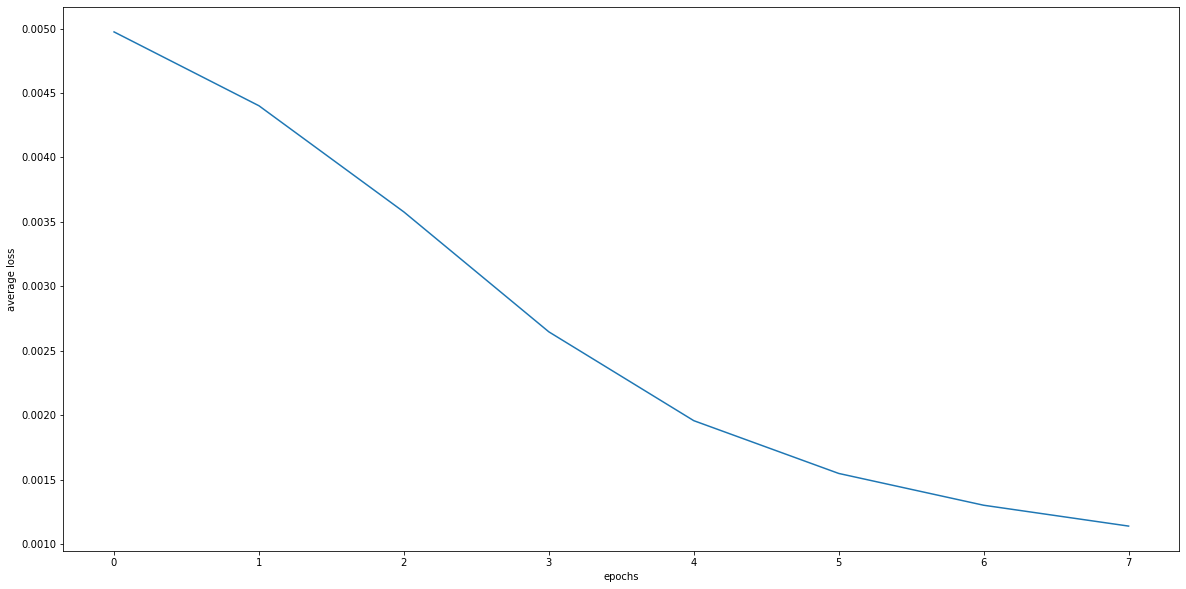

In [ ]:
losses_epoch = torch.tensor(losses_epoch, device = 'cpu')
plt.figure(figsize=(20, 10))
plt.plot(range(n_epochs), losses_epoch)
plt.xlabel("epochs")
plt.ylabel("average loss")
plt.show()

In [ ]:
filename = f'model_states/PR_LSTM_sequence_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
torch.save(model.state_dict(), filename)

In [40]:
filename = f'model_states/PR_LSTM_sequence_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
loaded_model = LSTM_seq2seq(input_size=FRAMES_IN, output_size=FRAMES_OUT)
loaded_model.load_state_dict(torch.load(filename))
if CUDA: 
    loaded_model = loaded_model.cuda()
loaded_model.eval()

LSTM_seq2seq(
  (encoder): Encoder(
    (encoder_lstm): LSTM(30, 300, batch_first=True)
  )
  (decoder): Decoder(
    (decoder_lstm): LSTM(300, 300, batch_first=True)
    (decoder_fc_1): Linear(in_features=300, out_features=150, bias=True)
    (decoder_fc_2): Linear(in_features=150, out_features=10, bias=True)
  )
)

# Testing

In [73]:
# get first I/O-sequence of test dataset for visualizing a prediction
x_test = 0
y_test = 0

# batch size = 0 for testing dataset
for batch in data_module.test_dataloader():
    x_test = batch["sequence"]
    y_test = batch["labels"]
    break

if CUDA:
    x_test = x_test.cuda()
    y_test = y_test.cuda()

print(x_test.shape, y_test.shape)

torch.Size([1, 2, 30]) torch.Size([1, 2, 10])


In [146]:
criterion = nn.MSELoss()

# make one prediction for visualization
with torch.no_grad():
    y_pred = loaded_model(x_test)
    loss = criterion(y_pred, y_test)

    # clean up tensor and round results to visually compare predicted sequence
    a = y_pred.squeeze(0)[0].tolist()
    a = [round(num, 4) for num in a]

    b = y_test.squeeze(0)[0].tolist()
    b = [round(num, 4) for num in b]

    print(f'predicted pitch: {a}\nreal pitch:\t {b}')
    print("loss:", round(loss.item(), 6))

# squeeze out batch size and convert into cpu format for plotting
x_test.squeeze(0).shape
input_sequence = x_test.squeeze(0).cpu()
output_sequence = y_test.squeeze(0).cpu()
predicted_sequence = y_pred.squeeze(0).cpu()
input_sequence.shape, output_sequence.shape, predicted_sequence.shape

predicted pitch: [0.0769, 0.0323, 0.056, 0.1101, 0.1088, 0.0566, 0.0411, 0.0491, 0.0194, -0.0379]
real pitch:	 [0.0782, -0.0112, 0.0431, 0.1098, 0.081, 0.0346, 0.0441, 0.0603, 0.0499, -0.0585]
loss: 0.000418


(torch.Size([2, 30]), torch.Size([2, 10]), torch.Size([2, 10]))

### Prediction vs. real on first test I/O-sequence

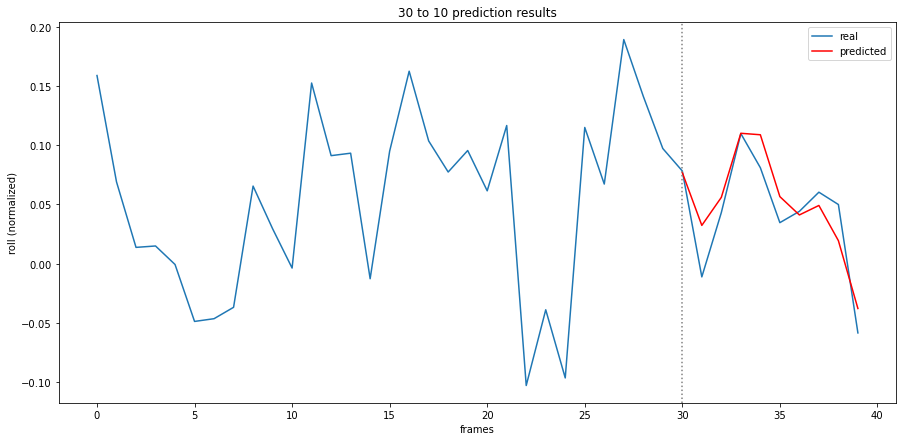

In [151]:
frames = np.arange(0,FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(frames, torch.cat((input_sequence[0], output_sequence[0])), label="real")
ax.plot(frames[FRAMES_IN:], predicted_sequence[0], color="red", label='predicted')
plt.axvline(x=30, color='grey', linestyle='dotted')
ax.set_xlabel('frames')
ax.set_ylabel('roll (normalized)')
ax.set_title('30 to 10 prediction results')
plt.legend()
plt.show()

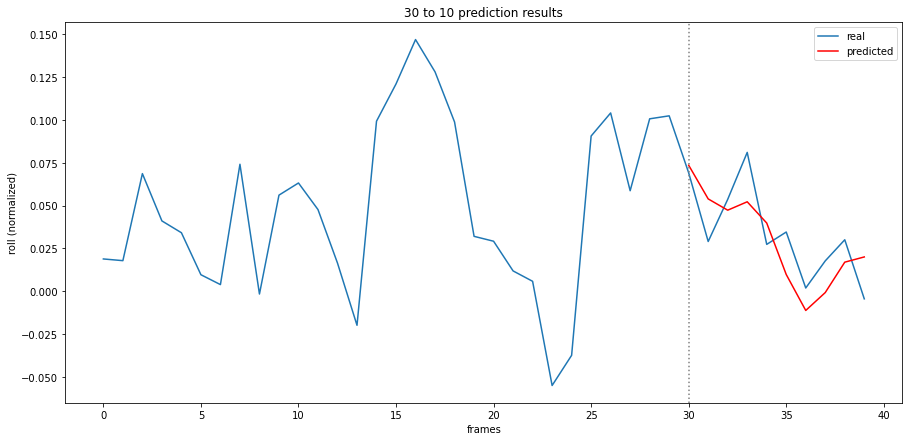

In [150]:
frames = np.arange(0,FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(frames, torch.cat((input_sequence[1], output_sequence[1])), label="real")
ax.plot(frames[FRAMES_IN:], predicted_sequence[1], color="red", label='predicted')
plt.axvline(x=30, color='grey', linestyle='dotted')
ax.set_xlabel('frames')
ax.set_ylabel('roll (normalized)')
ax.set_title('30 to 10 prediction results')
plt.legend()
plt.show()

### Full test loop

In [68]:
predictions = []
labels = []

with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader()):
        x_test = batch["sequence"]
        y_test = batch["labels"]

        if CUDA:
            x_test = x_test.cuda()
            y_test = y_test.cuda()

        output = loaded_model(x_test)
        predictions.append(output.cpu().squeeze(0))
        labels.append(y_test.cpu().squeeze(0))

  0%|          | 0/38988 [00:00<?, ?it/s]

In [90]:
# Predictions[0] = tensor object
# Predictions[0][0] = pitch sequence
# Predictions[0][1] = roll sequence

pitch_predictions = []
roll_predictions = []

pitch_label = []
roll_label = []

for i in range(len(predictions)):
    pitch_predictions.append(predictions[i][0])
    roll_predictions.append(predictions[i][1])
    pitch_label.append(labels[i][0])
    roll_label.append(labels[i][1])

pitch_predictions[0].shape, roll_predictions[0].shape, pitch_label[0].shape, roll_label[0].shape

(torch.Size([10]), torch.Size([10]), torch.Size([10]), torch.Size([10]))

### Average loss-per-frame over all datapoints

In [152]:
# function that returns a list with loss-values per frame
def loss_per_frame(predicted_sequence, real_sequence):
    loss_per_frame = []
    criterion = nn.MSELoss()
    if predicted_sequence.shape != real_sequence.shape:
        return loss_per_frame
    for i in range(len(predicted_sequence)):
        loss = criterion(predicted_sequence[i], real_sequence[i])
        loss_per_frame.append(loss.item())
    return loss_per_frame

In [153]:
# calculate mean loss per frame over all test data
total = len(pitch_predictions)
pitch_total = np.arange(10, dtype=np.float64)
roll_total = np.arange(10, dtype=np.float64)

for i in tqdm(range(len(pitch_predictions))):
    pitch_lpf = loss_per_frame(pitch_predictions[i], pitch_label[i])
    roll_lpf = loss_per_frame(roll_predictions[i], roll_label[i])
    pitch_total += pitch_lpf
    roll_total += roll_lpf

pitch_total /= total
roll_total /= total

  0%|          | 0/38988 [00:00<?, ?it/s]

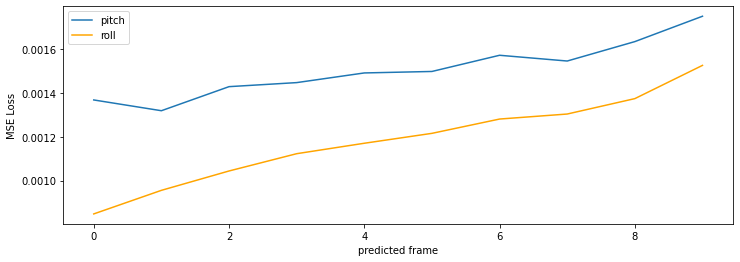

In [154]:
plt.figure(figsize=(12, 4))
plt.plot(pitch_total, label='pitch')
plt.plot(roll_total, color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### MSE results pitch

In [172]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(pitch_label[i], pitch_predictions[i]).item()
    loss0 += criterion(pitch_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Real prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Real prediction
   MSE: 0.00139
   RMSE: 0.0373
   RMSE denorm: 3.36°
Zero prediction
   MSE 0: 0.00513
   RMSE 0: 0.0716
   RMSE denorm: 6.44°
Improvement on zero prediction:
   MSE delta%: 369.06 %
   RMSE delta%: 191.96 %


### MSE results roll

In [173]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(roll_label[i], roll_predictions[i]).item()
    loss0 += criterion(roll_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Real prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Real prediction
   MSE: 0.00107
   RMSE: 0.0327
   RMSE denorm: 2.94°
Zero prediction
   MSE 0: 0.00653
   RMSE 0: 0.0808
   RMSE denorm: 7.27°
Improvement on zero prediction:
   MSE delta%: 610.28 %
   RMSE delta%: 247.09 %
